# Fermi-Hubbard model (H=A+B+C)

The one-dimensional Fermi-Hubbard Hamiltonian

$$
H = - J \sum_{j = 1}^{L - 1} \sum_{\sigma \in \{ \uparrow, \downarrow \}} c_{j, \sigma}^\dagger c_{j + 1, \sigma} + \text{h.c.} + U \sum_{j} n_{j\uparrow} n_{j\downarrow}
$$

where $j = 1, ..., L$ denotes site/orbital and $\sigma \in \{ \uparrow, \downarrow \}$ denotes spin. 

In [1]:
# try:
#     import openfermion
# except ImportError:
#     !pip install git+https://github.com/quantumlib/OpenFermion.git@master#egg=openfermion

from lattice_hamiltonians import *

one_body_terms: 
 [-1.0 [0^ 2] +
-1.0 [2^ 0], -1.0 [1^ 3] +
-1.0 [3^ 1], -1.0 [2^ 4] +
-1.0 [4^ 2], -1.0 [3^ 5] +
-1.0 [5^ 3], -1.0 [4^ 6] +
-1.0 [6^ 4], -1.0 [5^ 7] +
-1.0 [7^ 5]]
one_body_L:  6
one_body[0]: 
   (4, 1)	(-1+0j)
  (6, 3)	(1+0j)
  (1, 4)	(-1+0j)
  (3, 6)	(1+0j)
bi_group_01: 
 [-1.0 [0^ 2] +
-1.0 [2^ 0], -1.0 [1^ 3] +
-1.0 [3^ 1], -1.0 [4^ 6] +
-1.0 [6^ 4], -1.0 [5^ 7] +
-1.0 [7^ 5]]
bi_group_23: 
 [-1.0 [2^ 4] +
-1.0 [4^ 2], -1.0 [3^ 5] +
-1.0 [5^ 3]]
tri_group_0: 
 [-1.0 [0^ 2] +
-1.0 [2^ 0], -1.0 [3^ 5] +
-1.0 [5^ 3]]
tri_group_1: 
 [-1.0 [1^ 3] +
-1.0 [3^ 1], -1.0 [4^ 6] +
-1.0 [6^ 4]]
tri_group_2: 
 [-1.0 [2^ 4] +
-1.0 [4^ 2], -1.0 [5^ 7] +
-1.0 [7^ 5]]
(256, 256)
(256, 256)
(256, 256)


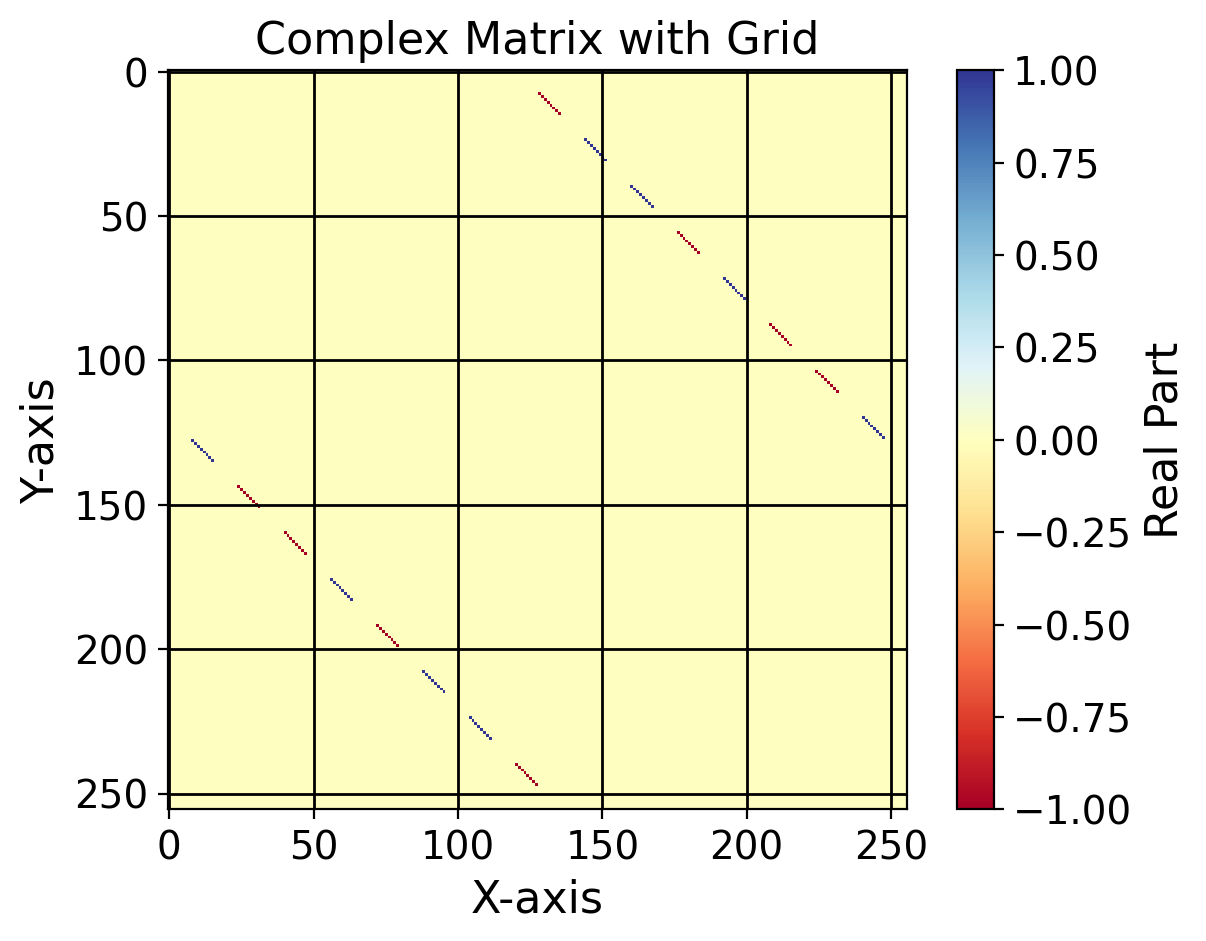

In [2]:
## parameters of Hubbard Hamiltonian and evolution
n = 4
t = n * 5
epsilon = 1e-3
J = -1
hubbard = hubbard_openfermion(n, J, verbose=True)
print('bi_group_01: \n', hubbard.one_body_01)
print('bi_group_23: \n', hubbard.one_body_23)
print('tri_group_0: \n', hubbard.one_body_0)
print('tri_group_1: \n', hubbard.one_body_1)
print('tri_group_2: \n', hubbard.one_body_2)
# print('commutator: ', commutator(hubbard.one_body_sparse[5], hubbard.one_body_sparse[9]))

## binary grouping
bi_group = [sum(hubbard.one_body_01_sparse), sum(hubbard.one_body_23_sparse)]
# print(bi_group)
## triple grouping
tri_group = [sum(hubbard.one_body_0_sparse), sum(hubbard.one_body_1_sparse), sum(hubbard.one_body_2_sparse)]
for item in tri_group:
    print(item.shape)

hubbard.two_body_fops
# matrix_plot(hubbard.one_body_01_sparse[0])
matrix_plot(commutator(hubbard.one_body_sparse[0], hubbard.one_body_sparse[2]))
# matrix_plot(commutator(hubbard.two_body_sparse[3], hubbard.one_body_sparse[2]))

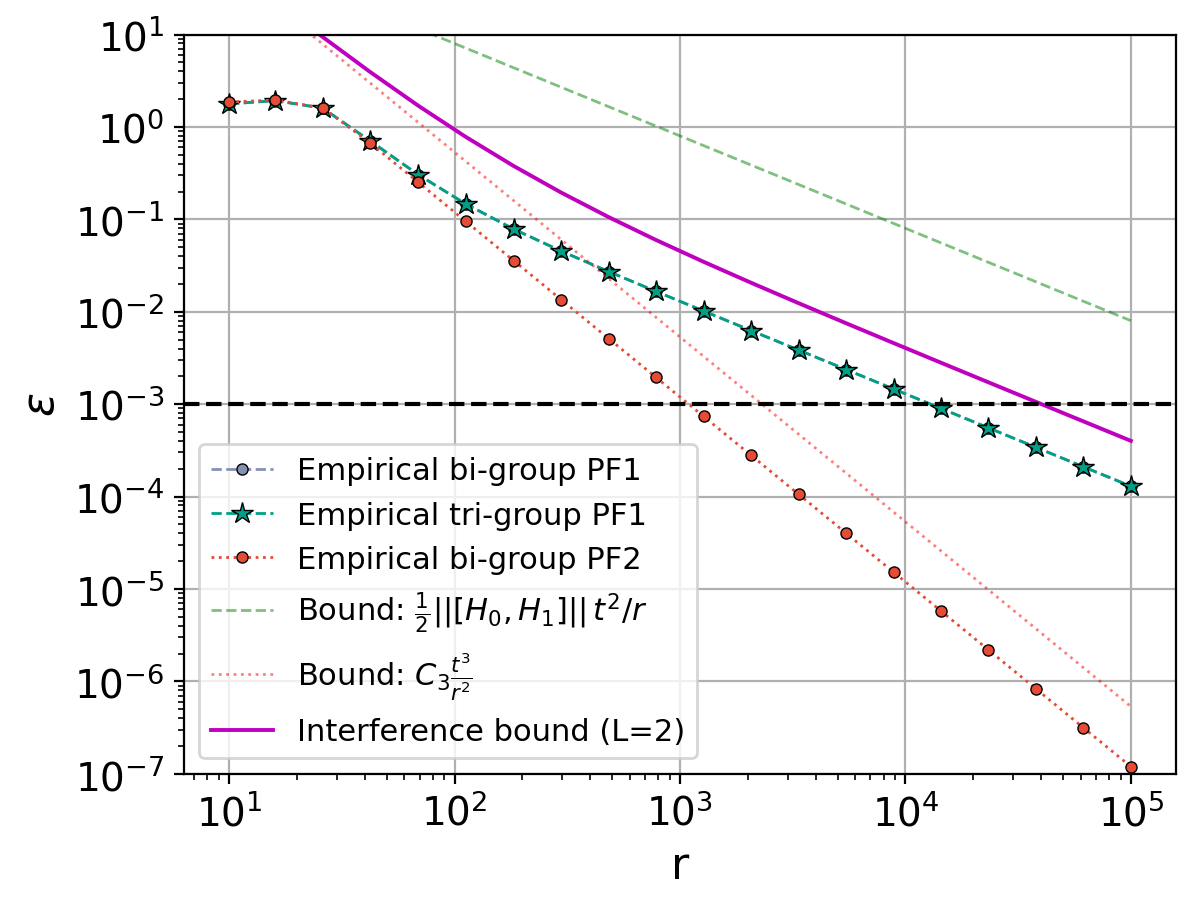

In [3]:
r_list = np.logspace(1, 5, num=20, dtype=int)
exact_U = expm(-1j * t * sum(bi_group))

## empirical PF1 and PF2
pf1_bi_list = [op_error(matrix_power(unitary_matrix_product(bi_group, t=t/r), r), exact_U) for r in r_list]
pf2_bi_list = [op_error(matrix_power(unitary_matrix_product(bi_group, t=t/(2*r)) @ unitary_matrix_product(bi_group[::-1], t=t/(2*r)), r), exact_U) for r in r_list]

pf1_tri_list = [op_error(matrix_power(unitary_matrix_product(tri_group, t=t/r), r), exact_U) for r in r_list]

## interference bound
bound = [interference_bound(bi_group, t, r)[0] for r in r_list]
e1 = np.array([interference_bound(bi_group, t, r)[1] for r in r_list])
e2 = np.array([interference_bound(bi_group, t, r)[2] for r in r_list])
e3 = np.array([interference_bound(bi_group, t, r)[3] for r in r_list])

data_plot(r_list, pf1_bi_list, '.--', label= 'Empirical bi-group PF1')
data_plot(r_list, pf1_tri_list, '*--', label= 'Empirical tri-group PF1')
data_plot(r_list, pf2_bi_list, '.:', label= 'Empirical bi-group PF2')
# data_plot(r_list, e1, 'y--', alpha=0.5, label=r'Bound: $\min(||H_0||,||H_1||)\, t/r$', linewidth=1) # C_1
data_plot(r_list, e2, 'g--', alpha=0.5, label=r'Bound: $\frac{1}{2}||[H_0,H_1]||\, t^2/r$', linewidth=1) # C_2
data_plot(r_list, e3, 'r:', alpha=0.5, label=r'Bound: $C_3\frac{t^3}{r^2}$', linewidth=1)
data_plot(r_list, bound, 'm-', linewidth=1.4, label=r'Interference bound (L=2)')

# plot results bounds and empirical PF1 and PF2
plt.axhline(y=epsilon, c='k', linestyle='--', linewidth=1.5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('r')
plt.ylim(1e-7, 1e1)
plt.ylabel(r'$\epsilon$')
# plt.title(rf'(Fermi-Hubbard, n={n}, t={t}, J={J})')
plt.legend(fontsize=11, loc='lower left')
# plt.legend(fontsize=11, bbox_to_anchor=(1.05, 1.0), loc='upper left')
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig(f'./figs/hubbard_interference_n={n}_t={t}_J={J}.pdf', bbox_inches='tight')

In [4]:
# fig, axes = plt.subplot_mosaic(
#     """
#     AE
#     BF
#     CG
#     DH
#     """, constrained_layout=True, figsize=(12, 8))
axes

{'A': <Axes: label='A'>,
 'E': <Axes: label='E'>,
 'B': <Axes: label='B'>,
 'F': <Axes: label='F'>,
 'C': <Axes: label='C'>,
 'G': <Axes: label='G'>,
 'D': <Axes: label='D'>,
 'H': <Axes: label='H'>}

one_body_terms: 
 [-1.0 [0^ 2] +
-1.0 [2^ 0], -1.0 [1^ 3] +
-1.0 [3^ 1], -1.0 [2^ 4] +
-1.0 [4^ 2], -1.0 [3^ 5] +
-1.0 [5^ 3], -1.0 [4^ 6] +
-1.0 [6^ 4], -1.0 [5^ 7] +
-1.0 [7^ 5]]
one_body_L:  6
one_body[0]: 
   (4, 1)	(-1+0j)
  (6, 3)	(1+0j)
  (1, 4)	(-1+0j)
  (3, 6)	(1+0j)
one_body_terms: 
 [-1.0 [0^ 2] +
-1.0 [2^ 0], -1.0 [1^ 3] +
-1.0 [3^ 1], -1.0 [2^ 4] +
-1.0 [4^ 2], -1.0 [3^ 5] +
-1.0 [5^ 3], -1.0 [4^ 6] +
-1.0 [6^ 4], -1.0 [5^ 7] +
-1.0 [7^ 5]]
one_body_L:  6
one_body[0]: 
   (4, 1)	(-1+0j)
  (6, 3)	(1+0j)
  (1, 4)	(-1+0j)
  (3, 6)	(1+0j)


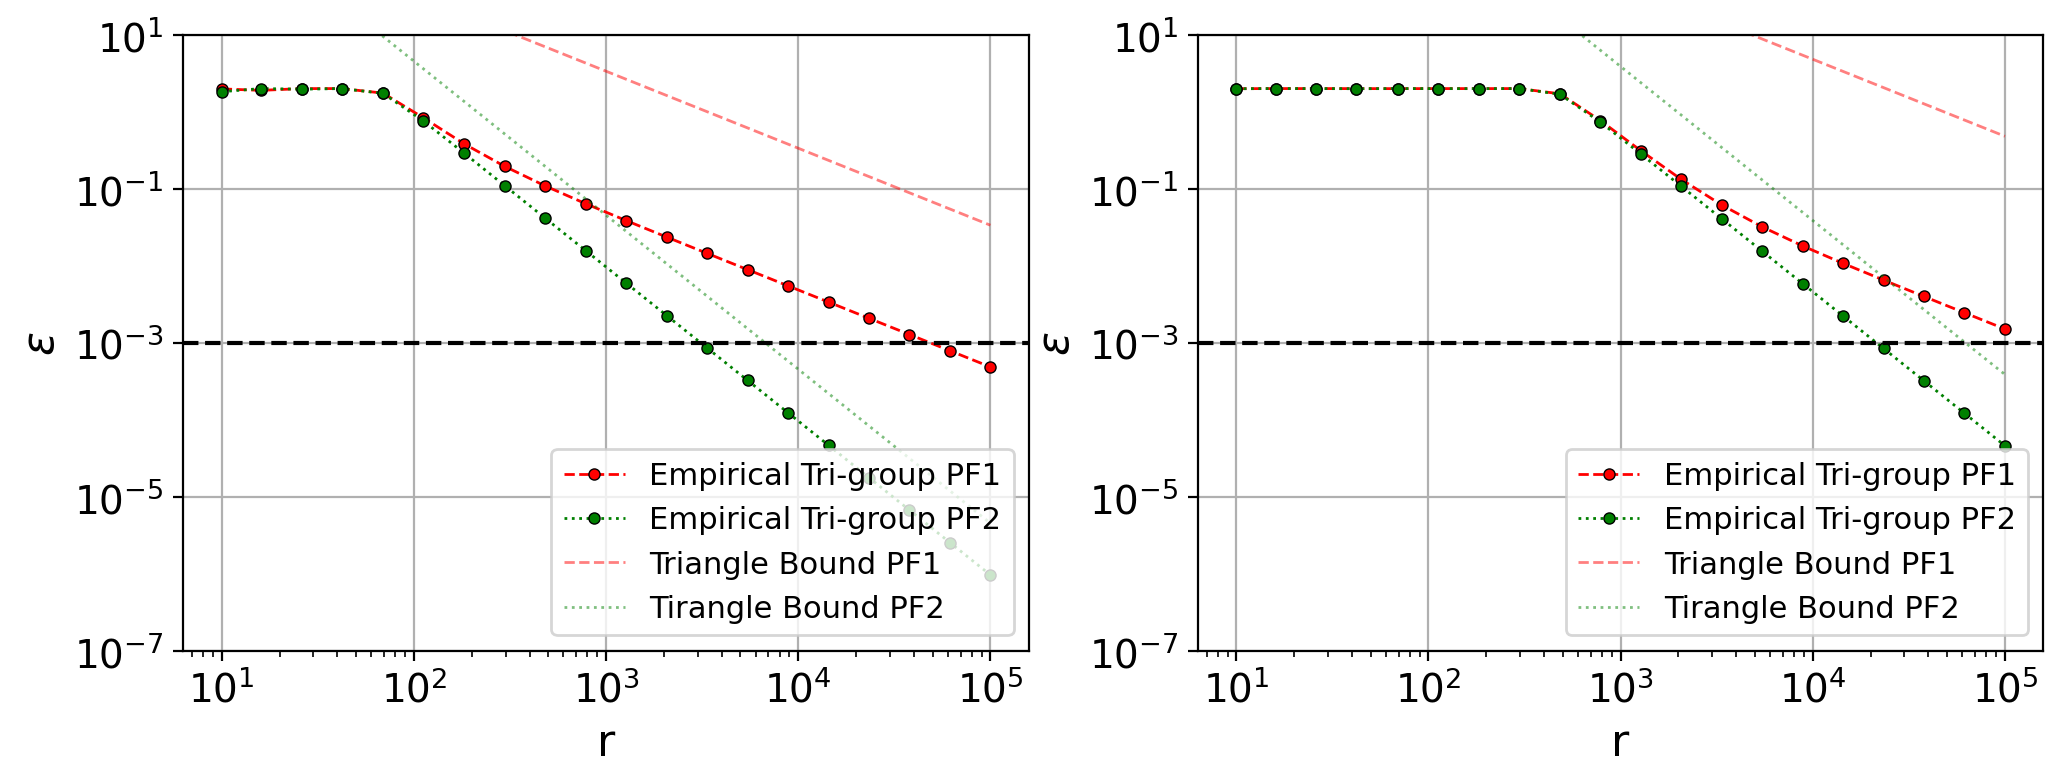

In [12]:
## parameters of Hubbard Hamiltonian and evolution
n = 4
t = n * 10
# r = 10000
epsilon = 1e-3
J = -1
# U = 10*J
U_list = [0.1, 10]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for i, U in enumerate(U_list):
    hubbard = hubbard_openfermion(n, U, verbose=True)

    r_list = np.logspace(1, 5, num=20, dtype=int)
    # t_list = np.logspace(1, 3, num=20, dtype=int)
    h_group = [sum(hubbard.one_body_01_sparse), sum(hubbard.one_body_23_sparse), sum(hubbard.two_body_sparse)]
    # exact_U = expm(-1j * t * sum(h_group))

    ## empirical PF1 and PF2
    pf1_list = [op_error(matrix_power(unitary_matrix_product(h_group, t=t/r), r), expm(-1j * t * sum(h_group))) for r in r_list]
    pf2_list = [op_error(matrix_power(unitary_matrix_product(h_group, t=t/(2*r)) @ unitary_matrix_product(h_group[::-1], t=t/(2*r)), r), expm(-1j * t * sum(h_group))) for r in r_list]

    e_pf1_tight_tri = np.array([tight_bound(h_group, 1, t, r) for r in r_list])
    e_pf2_tight_tri = np.array([tight_bound(h_group, 2, t, r) for r in r_list])

    data_plot(axes[i], r_list, pf1_list, 'r.--', label= 'Empirical Tri-group PF1')
    data_plot(axes[i], r_list, pf2_list, 'g.:', label= 'Empirical Tri-group PF2')
    # data_plot(r_list, e1, 'y--', alpha=0.5, label=r'Bound: $\min(||H_0||,||H_1||)\, t/r$', linewidth=1) # C_1
    data_plot(axes[i], r_list, e_pf1_tight_tri, 'r--', alpha=0.5, label=r'Triangle Bound PF1', linewidth=1) # C_2
    data_plot(axes[i], r_list, e_pf2_tight_tri, 'g:', alpha=0.5, label=r'Tirangle Bound PF2', linewidth=1)

# plot results bounds and empirical PF1 and PF2
    axes[i].axhline(y=epsilon, c='k', linestyle='--', linewidth=1.5)
    axes[i].set_xscale("log")
    axes[i].set_yscale("log")
    axes[i].set_xlabel('r')
    axes[i].set_ylim(1e-7, 1e1)
    axes[i].set_ylabel(r'$\epsilon$')
    # plt.title(rf'(Fermi-Hubbard, n={n}, t={t}, J={J})')
    axes[i].legend(fontsize=11, loc='lower right')
# plt.legend(fontsize=11, bbox_to_anchor=(1.05, 1.0), loc='upper left')
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
fig.savefig(f'./figs/hubbard_interference_n={n}_t={t}.pdf', bbox_inches='tight')

## Fixed r, change t

one_body_terms: 
 [-1.0 [0^ 2] +
-1.0 [2^ 0], -1.0 [1^ 3] +
-1.0 [3^ 1], -1.0 [2^ 4] +
-1.0 [4^ 2], -1.0 [3^ 5] +
-1.0 [5^ 3], -1.0 [4^ 6] +
-1.0 [6^ 4], -1.0 [5^ 7] +
-1.0 [7^ 5]]
one_body_L:  6
one_body[0]: 
   (4, 1)	(-1+0j)
  (6, 3)	(1+0j)
  (1, 4)	(-1+0j)
  (3, 6)	(1+0j)
one_body_terms: 
 [-1.0 [0^ 2] +
-1.0 [2^ 0], -1.0 [1^ 3] +
-1.0 [3^ 1], -1.0 [2^ 4] +
-1.0 [4^ 2], -1.0 [3^ 5] +
-1.0 [5^ 3], -1.0 [4^ 6] +
-1.0 [6^ 4], -1.0 [5^ 7] +
-1.0 [7^ 5]]
one_body_L:  6
one_body[0]: 
   (4, 1)	(-1+0j)
  (6, 3)	(1+0j)
  (1, 4)	(-1+0j)
  (3, 6)	(1+0j)


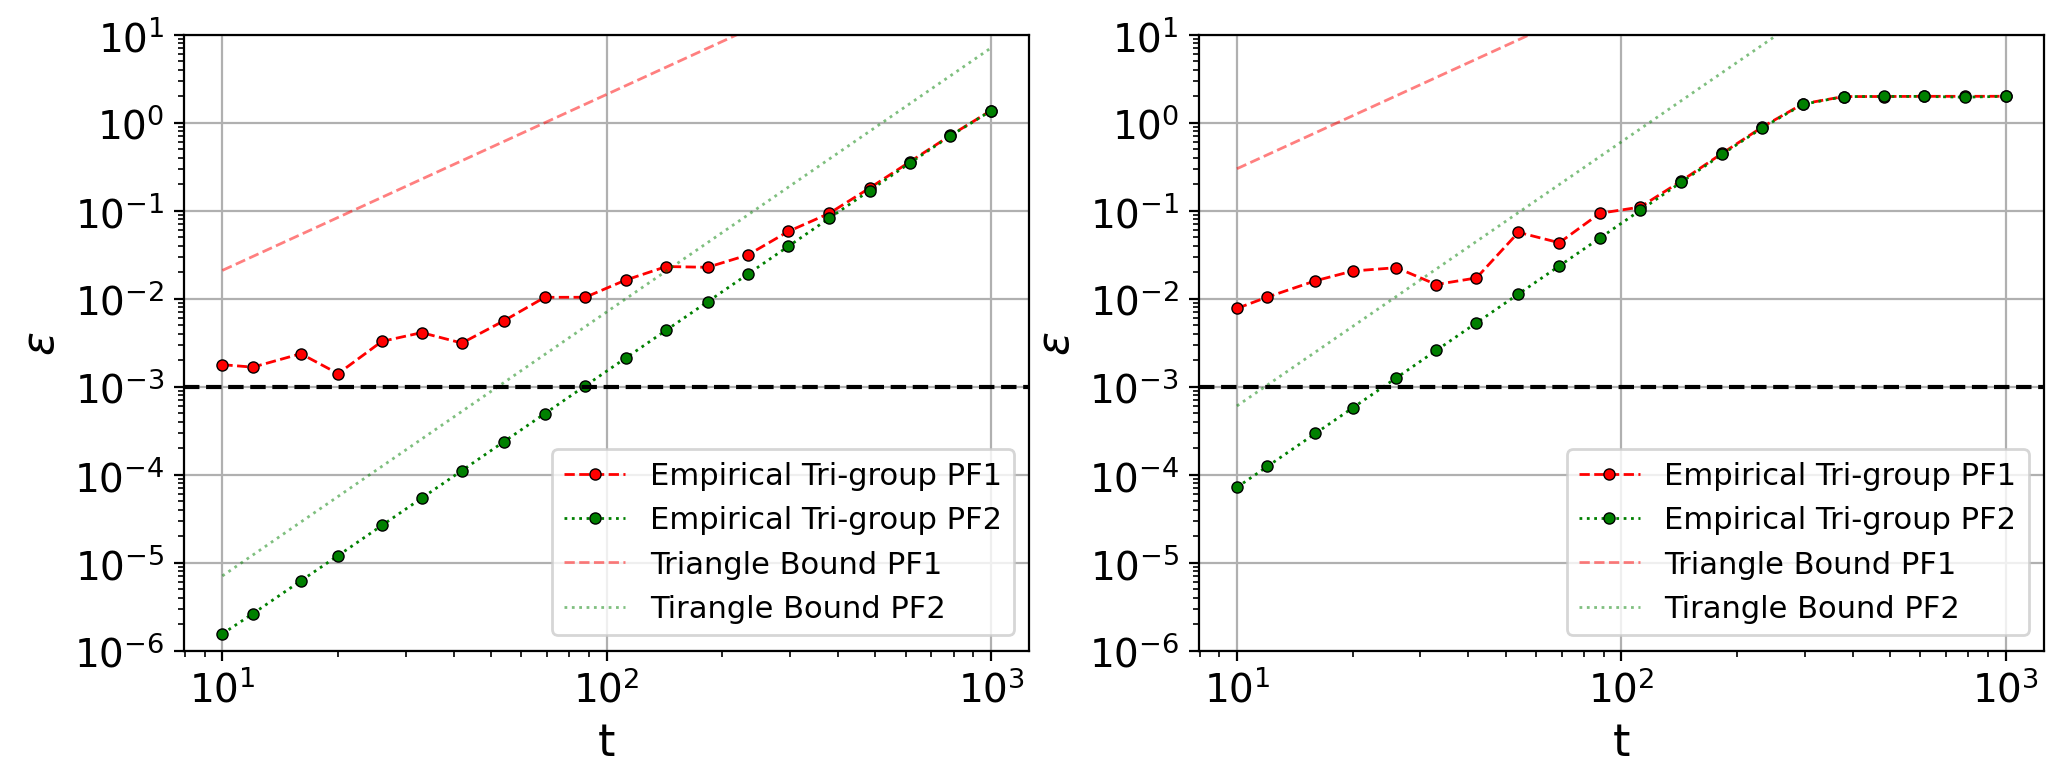

In [13]:
## parameters of Hubbard Hamiltonian and evolution
n = 4
# t = n * 1
r = 10000
epsilon = 1e-3
J = -1
# U = 10*J
U_list = [0.1, 10]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for i, U in enumerate(U_list):
    hubbard = hubbard_openfermion(n, U, verbose=True)

    # r_list = np.logspace(1, 5, num=20, dtype=int)
    t_list = np.logspace(1, 3, num=20, dtype=int)
    h_group = [sum(hubbard.one_body_01_sparse), sum(hubbard.one_body_23_sparse), sum(hubbard.two_body_sparse)]
    # exact_U = expm(-1j * t * sum(h_group))

    ## empirical PF1 and PF2
    pf1_list = [op_error(matrix_power(unitary_matrix_product(h_group, t=t/r), r), expm(-1j * t * sum(h_group))) for t in t_list]
    pf2_list = [op_error(matrix_power(unitary_matrix_product(h_group, t=t/(2*r)) @ unitary_matrix_product(h_group[::-1], t=t/(2*r)), r), expm(-1j * t * sum(h_group))) for t in t_list]

    e_pf1_tight_tri = np.array([tight_bound(h_group, 1, t, r) for t in t_list])
    e_pf2_tight_tri = np.array([tight_bound(h_group, 2, t, r) for t in t_list])

    data_plot(axes[i], t_list, pf1_list, 'r.--', label= 'Empirical Tri-group PF1')
    data_plot(axes[i], t_list, pf2_list, 'g.:', label= 'Empirical Tri-group PF2')
    # data_plot(r_list, e1, 'y--', alpha=0.5, label=r'Bound: $\min(||H_0||,||H_1||)\, t/r$', linewidth=1) # C_1
    data_plot(axes[i], t_list, e_pf1_tight_tri, 'r--', alpha=0.5, label=r'Triangle Bound PF1', linewidth=1) # C_2
    data_plot(axes[i], t_list, e_pf2_tight_tri, 'g:', alpha=0.5, label=r'Tirangle Bound PF2', linewidth=1)

# plot results bounds and empirical PF1 and PF2
    axes[i].axhline(y=epsilon, c='k', linestyle='--', linewidth=1.5)
    axes[i].set_xscale("log")
    axes[i].set_yscale("log")
    axes[i].set_xlabel('t')
    axes[i].set_ylim(1e-6, 1e1)
    axes[i].set_ylabel(r'$\epsilon$')
    # plt.title(rf'(Fermi-Hubbard, n={n}, t={t}, J={J})')
    axes[i].legend(fontsize=11, loc='lower right')
# plt.legend(fontsize=11, bbox_to_anchor=(1.05, 1.0), loc='upper left')
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
fig.savefig(f'./figs/hubbard_interference_n={n}_r={r}.pdf', bbox_inches='tight')

## Error V.S. t (fixed r)

In [33]:
## parameters of Hubbard Hamiltonian and evolution
from hubbard_hamiltonian import *

n = 5
# t = n * 5
epsilon = 1e-3
J = -1
hubbard = hubbard_openfermion(n, J, verbose=True)

## binary grouping
bi_group = [sum(hubbard.one_body_01_sparse), sum(hubbard.one_body_23_sparse)]
# print(bi_group)

## triple grouping
tri_group = [sum(hubbard.one_body_0_sparse), sum(hubbard.one_body_1_sparse), sum(hubbard.one_body_2_sparse)]

one_body_terms: 
 [-1.0 [0^ 2] +
-1.0 [2^ 0], -1.0 [1^ 3] +
-1.0 [3^ 1], -1.0 [2^ 4] +
-1.0 [4^ 2], -1.0 [3^ 5] +
-1.0 [5^ 3], -1.0 [4^ 6] +
-1.0 [6^ 4], -1.0 [5^ 7] +
-1.0 [7^ 5], -1.0 [6^ 8] +
-1.0 [8^ 6], -1.0 [7^ 9] +
-1.0 [9^ 7]]
one_body_L:  8
one_body[0]: 
   (4, 1)	(-1+0j)
  (6, 3)	(1+0j)
  (1, 4)	(-1+0j)
  (3, 6)	(1+0j)


In [36]:
t_list = np.logspace(0, 3, num=20, dtype=int)
# t_list = np.linspace(1, 200, num=20, dtype=int)
def exact_U(t):
    return expm(-1j * t * sum(bi_group))
# exact_U = expm(-1j * t * sum(bi_group))
r = 1000

## empirical PF1 and PF2
pf1_bi_list = [op_error(matrix_power(unitary_matrix_product(bi_group, t=t/r), r), exact_U(t)) for t in t_list]
pf2_bi_list = [op_error(matrix_power(unitary_matrix_product(bi_group, t=t/(2*r)) @ unitary_matrix_product(bi_group[::-1], t=t/(2*r)), r), exact_U(t)) for t in t_list]

pf1_tri_list = [op_error(matrix_power(unitary_matrix_product(tri_group, t=t/r), r), exact_U(t)) for t in t_list]

## interference bound
interf_bound = np.array([interference_bound(bi_group, t, r) for t in t_list])

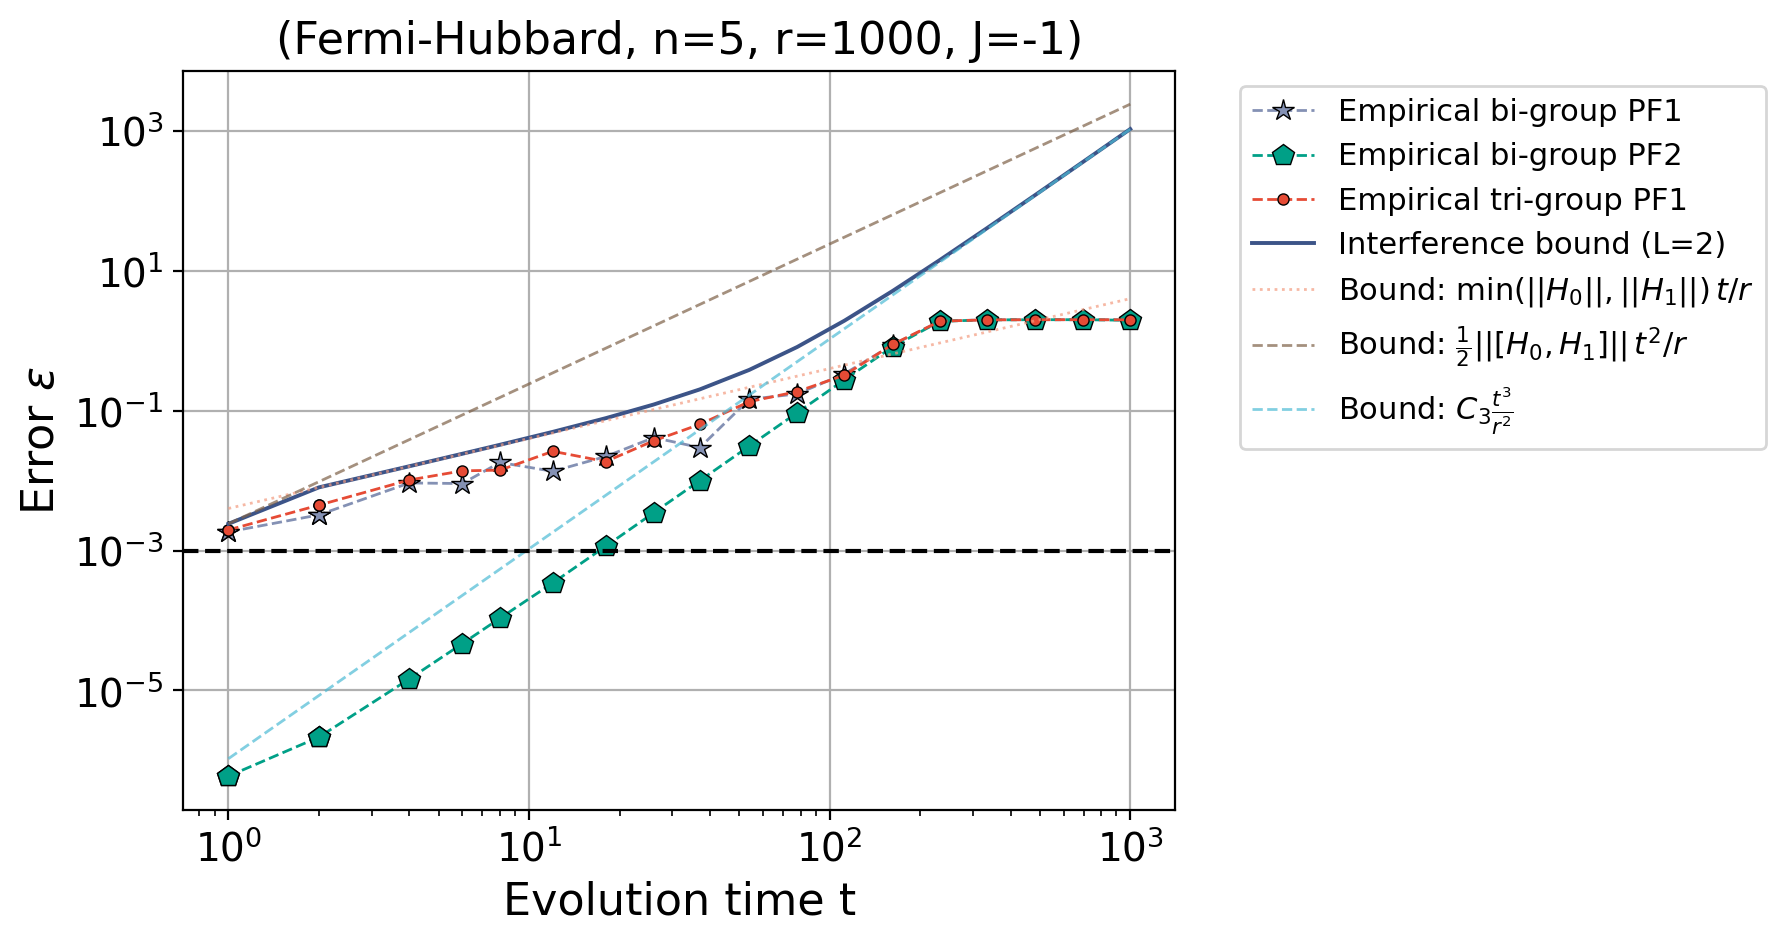

In [37]:
data_plot(t_list, pf1_bi_list, '*--', label= 'Empirical bi-group PF1')
data_plot(t_list, pf2_bi_list, 'p--', label= 'Empirical bi-group PF2')
data_plot(t_list, pf1_tri_list, '.--', label= 'Empirical tri-group PF1')

bound = interf_bound[:, 0]
e1 = interf_bound[:, 1]
e2 = interf_bound[:, 2]
e3 = interf_bound[:, 3]
data_plot(t_list, bound, '-', linewidth=1.4, label=r'Interference bound (L=2)')
data_plot(t_list, e1, ':', alpha=0.7, label=r'Bound: $\min(||H_0||,||H_1||)\, t/r$', linewidth=1) # C_1
data_plot(t_list, e2, '--', alpha=0.7, label=r'Bound: $\frac{1}{2}||[H_0,H_1]||\, t^2/r$', linewidth=1) # C_2
data_plot(t_list, e3, '--', alpha=0.7, label=r'Bound: $C_3\frac{t^3}{r^2}$', linewidth=1)

plt.axhline(y=epsilon, c='k', linestyle='--', linewidth=1.5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Evolution time t')
plt.ylabel(r'Error $\epsilon$')
plt.title(rf'(Fermi-Hubbard, n={n}, r={r}, J={J})')
plt.legend(fontsize=11, bbox_to_anchor=(1.05, 1.0), loc='upper left')
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig(f'../../figs/hubbard_interference_n={n}_r={r}_J={J}.pdf', bbox_inches='tight')

### Trotterization

### Preparing the initial state

#### Compare to direct diagonalization

### Computing the time-evolved charge and spin density

### Computing the charge and spin spread